In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Function to generate device locations
def generate_device_locations(device_count, bs_location, bs_radius):
  device_locations_polar = np.column_stack([bs_radius * np.sqrt(np.random.rand(device_count)), 2 * np.pi * np.random.rand(device_count)])
  rD = device_locations_polar[:, 0]
  thetaD = device_locations_polar[:, 1]
  device_locations = np.column_stack([bs_location[0] + rD * np.cos(thetaD), bs_location[1] + rD * np.sin(thetaD)])
  return device_locations, rD, thetaD

In [ ]:
# Function to generate event locations
def generate_event_locations(event_count, bs_location, bs_radius):
  event_locations_polar = np.column_stack([bs_radius * np.sqrt(np.random.rand(event_count)), 2 * np.pi * np.random.rand(event_count)])
  rE = event_locations_polar[:, 0]
  thetaE = event_locations_polar[:, 1]
  event_locations = np.column_stack([bs_location[0] + rE * np.cos(thetaE), bs_location[1] + rE * np.sin(thetaE)])
  return event_locations, rE, thetaE

In [ ]:
# Function to calculate device probabilities based on event locations
def calculate_device_probabilities(device_count, event_count, xD, yD, xE, yE, k, D):
  device_probabilities = np.zeros(device_count)  # Initialize as a 1D array of zeros for each device
  for d in range(device_count):
    device_x_cord = xD[d]
    device_y_cord = yD[d]
    probMult = 1
    for e in range(event_count):
      event_x_cord = xE[e]
      event_y_cord = yE[e]
      distance = np.sqrt((device_x_cord - event_x_cord) ** 2 + (device_y_cord - event_y_cord) ** 2)
      probMult *= (1 - (np.exp(- distance / k) - np.exp(- D / k))/(1 - np.exp(- D / k)))
    device_probabilities[d] = 1 - probMult
  return device_probabilities

In [ ]:
# Function to generate device alarm status
def generate_device_alarm_status(device_count, device_probabilities):
  random_numbers = np.random.rand(device_count)
  alarm_status = random_numbers < device_probabilities
  return alarm_status

In [ ]:
# Function to generate device transmission status
def generate_device_transmission_status(device_count, device_alarm_status):
  transmission_probability = np.zeros(device_count)
  transmission_probability[device_alarm_status] = 1
  random_numbers = np.random.rand(device_count)
  device_status = random_numbers < transmission_probability
  return device_status

In [ ]:
def modeling(device_count, event_count, bs_location, bs_radius, k, D, sparsity, num_samples):
    # Preallocate fixed-size NumPy arrays
    all_EventCount = np.zeros(num_samples, dtype=int)
    all_DeviceActiveCount = np.zeros(num_samples, dtype=int)
    all_DeviceProbability = np.zeros((num_samples, device_count), dtype=float)
    all_DeviceAlarmStatus = np.zeros((num_samples, device_count), dtype=bool)
    all_DeviceStatus = np.zeros((num_samples, device_count), dtype=bool)
    all_DeviceLocations = np.zeros((num_samples, device_count, 2), dtype=float)
    all_DeviceLocationsUncorrelated = np.zeros((num_samples, device_count, 2), dtype=float)
    all_DeviceLocationsPolar = np.zeros((num_samples, device_count, 2), dtype=float)
    all_EventLocations = np.zeros((num_samples, event_count, 2), dtype=float)
    all_EventLocationsPolar = np.zeros((num_samples, event_count, 2), dtype=float)

    total_samples = 0
    sample_index = 0
    device_active_mean = 0.0

    while sample_index < num_samples:
        total_samples += 1

        # Generate device locations
        device_locations, rD, thetaD = generate_device_locations(device_count, bs_location, bs_radius)
        xD, yD = device_locations[:, 0], device_locations[:, 1]

        device_locations_uncorrelated = device_locations.copy()
        np.random.shuffle(device_locations_uncorrelated)
        np.random.shuffle(device_locations_uncorrelated)

        # Generate event locations
        event_locations, rE, thetaE = generate_event_locations(event_count, bs_location, bs_radius)
        xE, yE = event_locations[:, 0], event_locations[:, 1]

        # Compute device probabilities using the exponential decay model
        device_probabilities = calculate_device_probabilities(device_count, event_count, xD, yD, xE, yE, k, D)

        # Generate device alarm and transmission status (vectorized)
        device_alarm_status = generate_device_alarm_status(device_count, device_probabilities)
        device_status = generate_device_transmission_status(device_count, device_alarm_status)
        device_active_count = np.sum(device_status)  # Count active devices

        # Running average update for device_active_mean
        device_active_mean += (device_active_count - device_active_mean) / total_samples

        print(f'Sample = {sample_index + 1}, Event Count = {event_count}, Active Devices = {device_active_count}, Mean = {device_active_mean:.3f}')

        if device_active_count == sparsity:
            # Store results in preallocated NumPy arrays
            all_EventCount[sample_index] = event_count
            all_DeviceActiveCount[sample_index] = device_active_count
            all_DeviceProbability[sample_index] = device_probabilities
            all_DeviceAlarmStatus[sample_index] = device_alarm_status
            all_DeviceStatus[sample_index] = device_status
            all_DeviceLocations[sample_index] = device_locations
            all_DeviceLocationsUncorrelated[sample_index] = device_locations_uncorrelated
            all_DeviceLocationsPolar[sample_index] = np.column_stack([rD, thetaD])
            all_EventLocations[sample_index] = event_locations
            all_EventLocationsPolar[sample_index] = np.column_stack([rE, thetaE])

            sample_index += 1  # Move to the next sample
            print(f'Sample {sample_index} completed')

    # Mount Google Drive and save data
    drive.mount('/content/drive')
    np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz',
        all_EventCount=all_EventCount,
        all_DeviceActiveCount=all_DeviceActiveCount,
        all_DeviceProbability=all_DeviceProbability,
        all_DeviceAlarmStatus=all_DeviceAlarmStatus,
        all_DeviceStatus=all_DeviceStatus,
        all_DeviceLocations=all_DeviceLocations,
        all_DeviceLocationsUncorrelated=all_DeviceLocationsUncorrelated,
        all_DeviceLocationsPolar=all_DeviceLocationsPolar,
        all_EventLocations=all_EventLocations,
        all_EventLocationsPolar=all_EventLocationsPolar,
        device_count=device_count,
        event_count=event_count,
        bs_location=bs_location,
        bs_radius=bs_radius,
        k=k,
        sparsity=sparsity,
        num_samples=num_samples,
        D=D
    )

    print('Saved to Google Drive')


In [ ]:
# Run the modeling with parameters
modeling(device_count=400,
        event_count=1,
        bs_location=np.array([100, 100]) / 2,
        bs_radius=40,
        k=5.725,
        D=20,
        sparsity=10,
        num_samples=1000)

Streaming output truncated to the last 5000 lines.
Sample 523 completed
Sample = 524, Event Count = 1, Active Devices = 15, Mean = 10.089
Sample = 524, Event Count = 1, Active Devices = 6, Mean = 10.088
Sample = 524, Event Count = 1, Active Devices = 9, Mean = 10.088
Sample = 524, Event Count = 1, Active Devices = 13, Mean = 10.088
Sample = 524, Event Count = 1, Active Devices = 13, Mean = 10.089
Sample = 524, Event Count = 1, Active Devices = 12, Mean = 10.089
Sample = 524, Event Count = 1, Active Devices = 8, Mean = 10.089
Sample = 524, Event Count = 1, Active Devices = 8, Mean = 10.088
Sample = 524, Event Count = 1, Active Devices = 16, Mean = 10.089
Sample = 524, Event Count = 1, Active Devices = 6, Mean = 10.089
Sample = 524, Event Count = 1, Active Devices = 7, Mean = 10.088
Sample = 524, Event Count = 1, Active Devices = 6, Mean = 10.087
Sample = 524, Event Count = 1, Active Devices = 10, Mean = 10.087
Sample 524 completed
Sample = 525, Event Count = 1, Active Devices = 12, Mean

In [1]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x libavalon-framework-

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


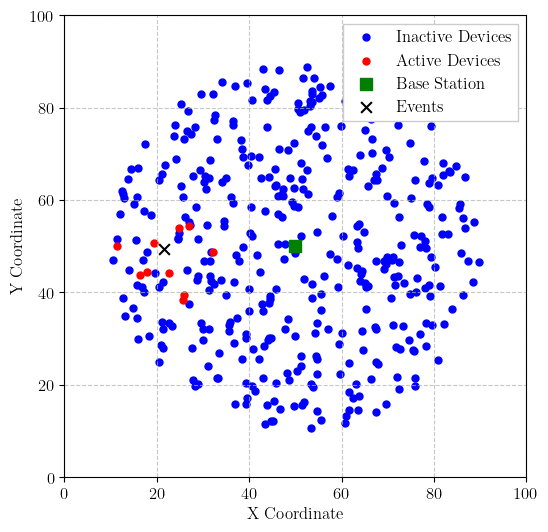

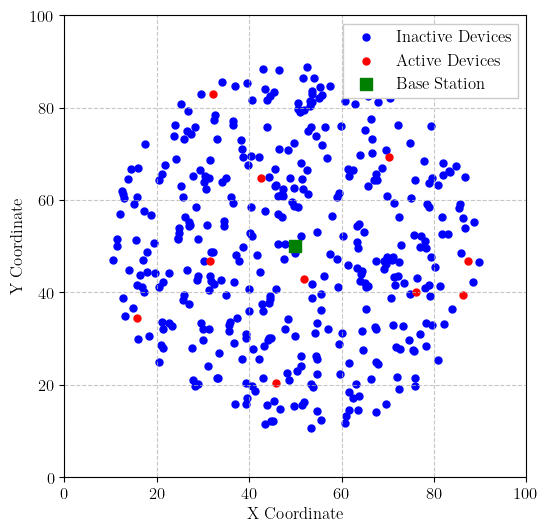

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

# Load saved data
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)

# Select sample index
sample_index = 240

# Extract data
DeviceStatus = data['all_DeviceStatus'][sample_index].astype(bool)  # Ensure boolean type
DeviceLocations = data['all_DeviceLocations'][sample_index]
DeviceLocationsUncorrelated = data['all_DeviceLocationsUncorrelated'][sample_index]
EventLocations = data['all_EventLocations'][sample_index]
bs_location = data['bs_location']

# Extract coordinates
xD, yD = DeviceLocations[:, 0], DeviceLocations[:, 1]
xDu, yDu = DeviceLocationsUncorrelated[:, 0], DeviceLocationsUncorrelated[:, 1]
xE, yE = EventLocations[:, 0], EventLocations[:, 1]

# Define common plot limits
x_min, x_max = 0, 100
y_min, y_max = 0, 100

# **EDAM: Event-Driven Activation**
plt.figure(figsize=(6, 6))
plt.scatter(xD[~DeviceStatus], yD[~DeviceStatus], color='b', label='Inactive Devices', s=25)
plt.scatter(xD[DeviceStatus], yD[DeviceStatus], color='r', label='Active Devices', s=25)
plt.scatter(bs_location[0], bs_location[1], color='g', marker='s', label='Base Station', s=70)  # Increased size
plt.scatter(xE, yE, color='k', marker='x', label='Events', s=60)  # Slightly reduced event size
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.legend(fontsize=12, loc='upper right', frameon=True, framealpha=1, facecolor='white', fancybox=False)  # MATLAB-like sharp edges
plt.tick_params(axis='both', labelsize=12)
plt.savefig('/content/drive/My Drive/Github/mtc-device-activation/figures/EDAM_activation_model.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# **RAM: Random Activation**
plt.figure(figsize=(6, 6))
plt.scatter(xDu[~DeviceStatus], yDu[~DeviceStatus], color='b', label='Inactive Devices', s=25)
plt.scatter(xDu[DeviceStatus], yDu[DeviceStatus], color='r', label='Active Devices', s=25)
plt.scatter(bs_location[0], bs_location[1], color='g', marker='s', label='Base Station', s=70)  # Increased size
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.legend(fontsize=12, loc='upper right', frameon=True, framealpha=1, facecolor='white', fancybox=False)  # MATLAB-like sharp edges
plt.tick_params(axis='both', labelsize=12)
plt.savefig('/content/drive/My Drive/Github/mtc-device-activation/figures/RAM_activation_model.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()
plt.close()


In [ ]:
data['all_DeviceStatus'].shape

(1000, 400)